# Sistema IoT para control de siembras basado en Big Data y ML
**TFM – Cuaderno de trabajo**  
**Fecha:** 2025-10-06

---

## Resumen
Este proyecto propone el diseño de un sistema inteligente para apoyar el **control del riego** en cultivos empleando **IoT, Big Data y aprendizaje automático**. A partir de datos sobre suelo, tipo de planta, estado de plántula, humedad del suelo (MOI), temperatura y humedad ambiente, se entrena un modelo que decide si un terreno **necesita riego** (`result`=1) o **no** (`result`=0).  
Los datos se generarán mediante **simulaciones** que imitan condiciones reales y servirán para **entrenar y evaluar** los modelos. Este cuaderno guía el proceso paso a paso desde la carga de datos hasta un primer modelo base y su evaluación.

## Objetivos
1. Preparar y validar el dataset simulado.
2. Construir un **pipeline** reproducible de preprocesado + modelo.
3. Evaluar modelos base con **validación cruzada** y métricas adecuadas (F1, ROC-AUC, recall, etc.).
4. Guardar artefactos (modelo y transformaciones) para su uso futuro en un sistema IoT.

## Alcance
- **Datos:** 16,411 registros, 7 columnas (características ambientales y objetivo binario).
- **Modelado:** Enfoque supervisado para clasificación binaria (¿regar o no?).  
- **No** se realiza aún una descripción exhaustiva del dataset; nos centramos en un **primer pipeline operativo**.

---


## Entorno y dependencias


In [ ]:
%pip install -U pandas numpy scikit-learn matplotlib joblib xgboost
%pip install -U imbalanced-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 MB 9.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.0.4
    Uninstalling xgboost-3.0.4:
      Successfully uninstalled xgboos

## Imports y configuración

In [10]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, roc_auc_score, f1_score,
                             precision_score, recall_score, confusion_matrix)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import joblib
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## Carga rápida de datos


In [11]:
# Ruta al CSV
DATA_PATH = Path("/content/cropdata_updated.csv")

df = pd.read_csv(DATA_PATH)
print("Shape inicial:", df.shape)
df.head()

Shape inicial: (16411, 7)


,crop ID,soil_type,Seedling Stage,MOI,temp,humidity,result
0,Wheat,Black Soil,Germination,1,25,80.0,1
1,Wheat,Black Soil,Germination,2,26,77.0,1
2,Wheat,Black Soil,Germination,3,27,74.0,1
3,Wheat,Black Soil,Germination,4,28,71.0,1
4,Wheat,Black Soil,Germination,5,29,68.0,1


##  Chequeos y limpieza


In [12]:
# Comprobaciones iniciales (nombres de columnas, tipos, valores únicos clave)
print("Columnas:", list(df.columns))
print("\nTipos:\n", df.dtypes)


for c in ['crop ID','soil_type','Seedling Stage']:
    if c in df.columns:
        print(f"\n{c} - nº categorías:", df[c].nunique())
        print(df[c].value_counts().head())


Columnas: ['crop ID', 'soil_type', 'Seedling Stage', 'MOI', 'temp', 'humidity', 'result']

Tipos:
 crop ID            object
soil_type          object
Seedling Stage     object
MOI                 int64
temp                int64
humidity          float64
result              int64
dtype: object

crop ID - nº categorías: 5
crop ID
Wheat     6213
Chilli    2764
Potato    2504
Carrot    2475
Tomato    2455
Name: count, dtype: int64

soil_type - nº categorías: 7
soil_type
Clay Soil     3726
Sandy Soil    3678
Red Soil      2763
Loam Soil     2376
Black Soil    1929
Name: count, dtype: int64

Seedling Stage - nº categorías: 8
Seedling Stage
Flowering                                        3002
Seedling Stage                                   2931
Vegetative Growth / Root or Tuber Development    2902
Germination                                      2895
Pollination                                      2196
Name: count, dtype: int64


In [13]:
for c in ['crop ID','soil_type','Seedling Stage']:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip()

print("Nulos:\n", df.isna().sum())

Nulos:
 crop ID           0
soil_type         0
Seedling Stage    0
MOI               0
temp              0
humidity          0
result            0
dtype: int64


In [14]:
# Eliminación de duplicados
dups_antes = df.duplicated().sum()
df = df.drop_duplicates()
dups_despues = df.duplicated().sum()
print(f"Duplicados eliminados: {dups_antes - dups_despues}")
print("Shape tras drop_duplicates:", df.shape)

Duplicados eliminados: 128
Shape tras drop_duplicates: (16283, 7)


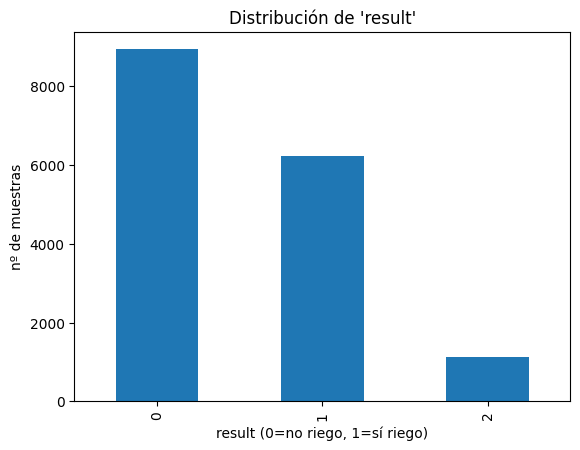

In [15]:
#Distribución inicial de result
if 'result' in df.columns:
    plt.figure()
    df['result'].value_counts().sort_index().plot(kind='bar')
    plt.title("Distribución de 'result'")
    plt.xlabel("result (0=no riego, 1=sí riego)")
    plt.ylabel("nº de muestras")
    plt.show()

In [16]:
print("Valores únicos en 'result':", sorted(df['result'].unique()))
print("\nFrecuencias:")
print(df['result'].value_counts().sort_index())

Valores únicos en 'result': [np.int64(0), np.int64(1), np.int64(2)]

Frecuencias:
result
0    8934
1    6227
2    1122
Name: count, dtype: int64


In [17]:
# Eliminar filas con 'result' fuera de {0, 1}
valid_labels = {0, 1}
mask_valid = df['result'].isin(valid_labels)
num_invalid = (~mask_valid).sum()
print(f"Filas a eliminar por 'result' inválido: {num_invalid}")

df = df[mask_valid].copy().reset_index(drop=True)

# Verificación
assert set(df['result'].unique()).issubset(valid_labels), "Aún quedan valores no binarios en 'result'"
print("'result' es ahora estrictamente binaria {0,1}. Shape:", df.shape)

Filas a eliminar por 'result' inválido: 1122
'result' es ahora estrictamente binaria {0,1}. Shape: (15161, 7)


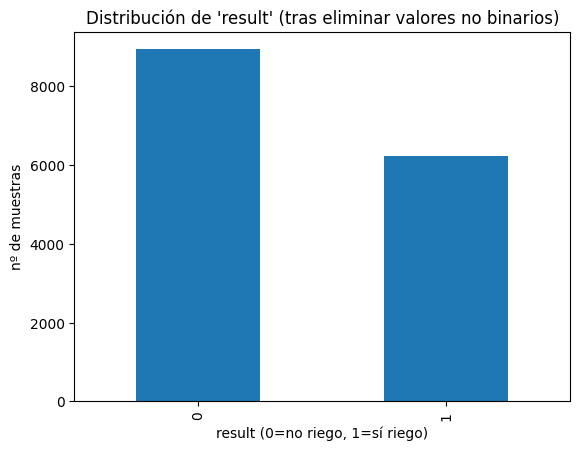

In [18]:
#Distribución final de result
plt.figure()
df['result'].value_counts().sort_index().plot(kind='bar')
plt.title("Distribución de 'result' (tras eliminar valores no binarios)")
plt.xlabel("result (0=no riego, 1=sí riego)")
plt.ylabel("nº de muestras")
plt.show()

<Figure size 640x480 with 0 Axes>

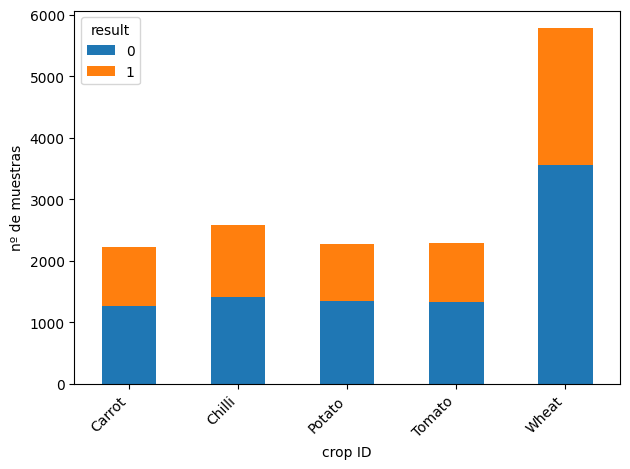

<Figure size 640x480 with 0 Axes>

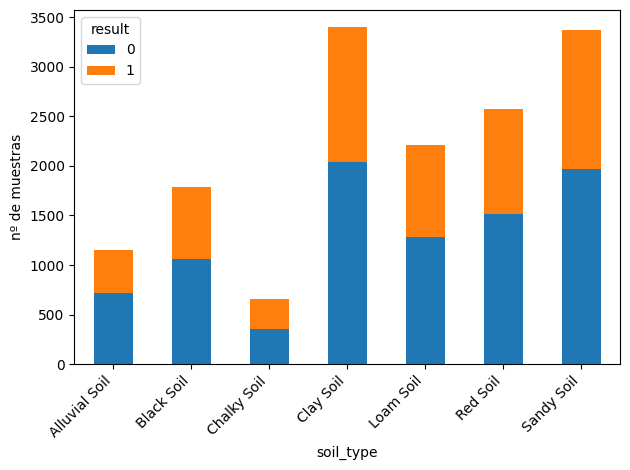

<Figure size 640x480 with 0 Axes>

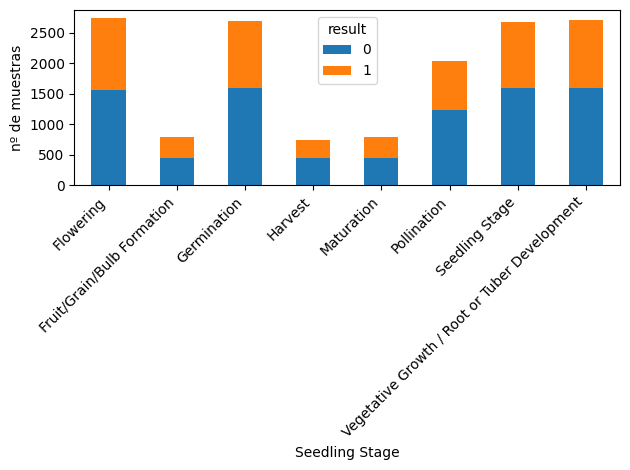

In [19]:
# Gráficas categóricas vs result (barras apiladas)
if 'crop ID' in df.columns and 'result' in df.columns:
    plt.figure()
    pd.crosstab(df['crop ID'], df['result']).plot(kind='bar', stacked=True)
    plt.xlabel("crop ID"); plt.ylabel("nº de muestras")
    plt.legend(title='result')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

if 'soil_type' in df.columns and 'result' in df.columns:
    plt.figure()
    pd.crosstab(df['soil_type'], df['result']).plot(kind='bar', stacked=True)
    plt.xlabel("soil_type"); plt.ylabel("nº de muestras")
    plt.legend(title='result')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

if 'Seedling Stage' in df.columns and 'result' in df.columns:
    plt.figure()
    pd.crosstab(df['Seedling Stage'], df['result']).plot(kind='bar', stacked=True)
    plt.xlabel("Seedling Stage"); plt.ylabel("nº de muestras")
    plt.legend(title='result')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


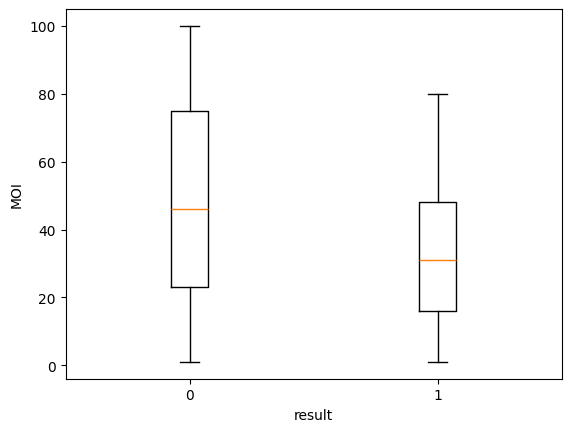

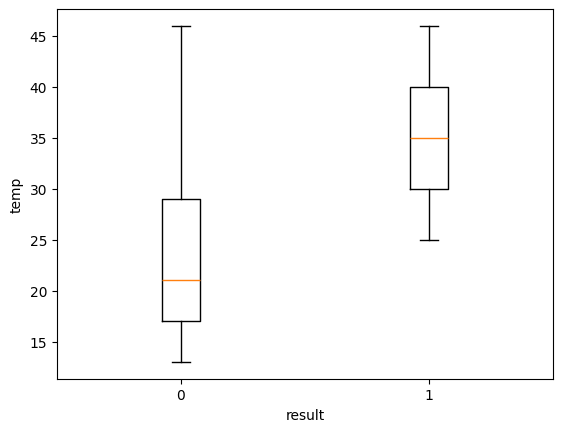

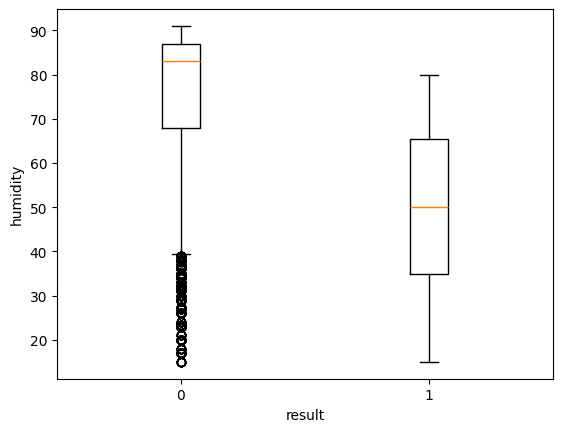

In [20]:
# Gráficas numéricas vs result (boxplot)
for nc in [c for c in ['MOI','temp','humidity'] if c in df.columns]:
    plt.figure()
    data0 = df.loc[df['result']==0, nc].values
    data1 = df.loc[df['result']==1, nc].values
    plt.boxplot([data0, data1], labels=['0','1'])
    plt.xlabel("result"); plt.ylabel(nc)
    plt.show()

In [21]:
# Cálculo de límites de outliers por IQR (sin eliminar todavía)
def iqr_bounds(s: pd.Series, k: float = 1.5):
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    return q1 - k*iqr, q3 + k*iqr

bounds = {}
for c in [c for c in ['MOI','temp','humidity'] if c in df.columns]:
    lo, hi = iqr_bounds(df[c], k=1.5)
    bounds[c] = (lo, hi)

print("Límites IQR:")
for c,(lo,hi) in bounds.items():
    print(f"  {c}: [{lo:.3f}, {hi:.3f}]")

Límites IQR:
  MOI: [-44.000, 124.000]
  temp: [-5.500, 62.500]
  humidity: [-13.500, 142.500]


In [22]:
# Identificación de outliers (listado de índices por columna y conjunto total)
outlier_idx_por_col = {}
for c,(lo,hi) in bounds.items():
    mask_out = ~df[c].between(lo, hi)
    outlier_idx_por_col[c] = df.index[mask_out].tolist()
    print(f"{c} - nº outliers: {len(outlier_idx_por_col[c])}")

# Unión de todos los outliers (cualquier numérica)
outliers_union = sorted(set().union(*outlier_idx_por_col.values())) if len(outlier_idx_por_col)>0 else []
print("\nTotal de filas marcadas como outliers (unión):", len(outliers_union))

MOI - nº outliers: 0
temp - nº outliers: 0
humidity - nº outliers: 0

Total de filas marcadas como outliers (unión): 0


## 5. División train/validación
Usamos una partición **estratificada** para mantener el balance de clases.

In [23]:
# Selección de variables (X, y) tras limpieza y codificación
from pprint import pprint

RANDOM_STATE = 42

feature_cols = [c for c in ['MOI','temp','humidity','crop ID','soil_type','Seedling Stage'] if c in df.columns]
target_col = 'result'

X = df[feature_cols].copy()
y = df[target_col].astype(int).copy()

print("Features usadas:")
pprint(feature_cols)
print("Shape X, y:", X.shape, y.shape)



Features usadas:
['MOI', 'temp', 'humidity', 'crop ID', 'soil_type', 'Seedling Stage']
Shape X, y: (15161, 6) (15161,)


In [24]:
# Train/Valid split estratificado
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print("Train:", X_train.shape, " Valid:", X_valid.shape)
print("Distribución y_train:\n", y_train.value_counts(normalize=True))
print("Distribución y_valid:\n", y_valid.value_counts(normalize=True))

Train: (12128, 6)  Valid: (3033, 6)
Distribución y_train:
 result
0    0.589297
1    0.410703
Name: proportion, dtype: float64
Distribución y_valid:
 result
0    0.589186
1    0.410814
Name: proportion, dtype: float64


## 6. Pipeline de preprocesado y modelos base

In [25]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Selección de columnas
cat_cols = ["crop ID", "soil_type", "Seedling Stage"]
num_cols = ["MOI", "temp", "humidity"]

# Preprocesador: One-Hot para categóricas, el resto pasa tal cual
preprocess_trees = ColumnTransformer(
    transformers=[
        (
            "cat",
            OneHotEncoder(
                handle_unknown="ignore",
                min_frequency=5,
                sparse_output=False
            ),
            cat_cols
        ),
    ],
    remainder="passthrough"
)



In [26]:
#Definición de modelos
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier

models = {
    "XGBoost": Pipeline([
        ("prep", preprocess_trees),
        ("model", XGBClassifier(
            n_estimators=800, max_depth=6, learning_rate=0.05,
            subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
            n_jobs=-1, random_state=RANDOM_STATE,
            tree_method="hist", eval_metric="logloss", objective="binary:logistic"
        ))
    ]),
    "HistGB": Pipeline([
        ("prep", preprocess_trees),
        ("model", HistGradientBoostingClassifier(
            max_depth=None, learning_rate=0.08, max_iter=400, random_state=RANDOM_STATE
        ))
    ]),
    "RandomForest": Pipeline([
        ("prep", preprocess_trees),
        ("model", RandomForestClassifier(
            n_estimators=500, n_jobs=-1, class_weight="balanced", random_state=RANDOM_STATE
        ))
    ]),
    "ExtraTrees": Pipeline([
        ("prep", preprocess_trees),
        ("model", ExtraTreesClassifier(
            n_estimators=700, n_jobs=-1, class_weight="balanced", random_state=RANDOM_STATE
        ))
    ]),
    "GB": Pipeline([
        ("prep", preprocess_trees),
        ("model", GradientBoostingClassifier(
            n_estimators=500, learning_rate=0.05, subsample=0.9, random_state=RANDOM_STATE
        ))
    ]),
}



In [27]:
#Resultados de los modelos
from sklearn.model_selection import StratifiedKFold, cross_validate
import pandas as pd

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {"f1":"f1", "precision":"precision", "recall":"recall", "roc_auc":"roc_auc"}

results = {}
for name, pipe in models.items():
    scores = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    results[name] = {m: scores[f"test_{m}"].mean() for m in scoring}

results_df = pd.DataFrame(results).T.sort_values("f1", ascending=False)
print(results_df)
best_name = results_df.index[0]
best_pipe = models[best_name].fit(X, y)




                    f1  precision    recall   roc_auc
XGBoost       1.000000   1.000000  1.000000  1.000000
HistGB        0.999599   0.999198  1.000000  1.000000
GB            0.999438   0.998878  1.000000  1.000000
RandomForest  0.999278   0.998558  1.000000  1.000000
ExtraTrees    0.994021   0.999676  0.988436  0.999953


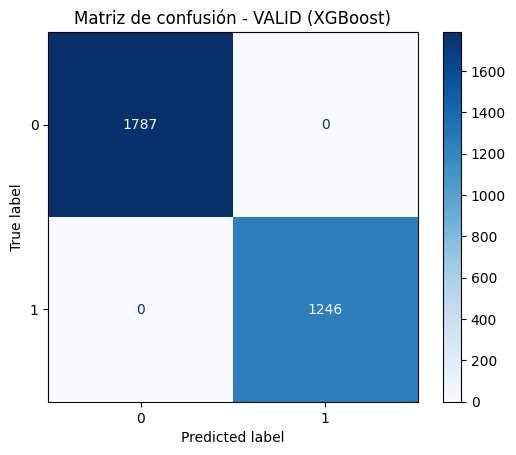

In [28]:
#Matriz de confusión del modelo seleccionado
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predicciones en VALID
y_pred_valid = best_pipe.predict(X_valid)

labels = getattr(best_pipe, "classes_", None)
if labels is None:
    labels = np.sort(np.unique(y))

ConfusionMatrixDisplay.from_predictions(
    y_valid, y_pred_valid,
    labels=labels,
    display_labels=labels,
    cmap='Blues',
    values_format='d'
)
plt.title(f"Matriz de confusión - VALID ({best_name})")
plt.show()





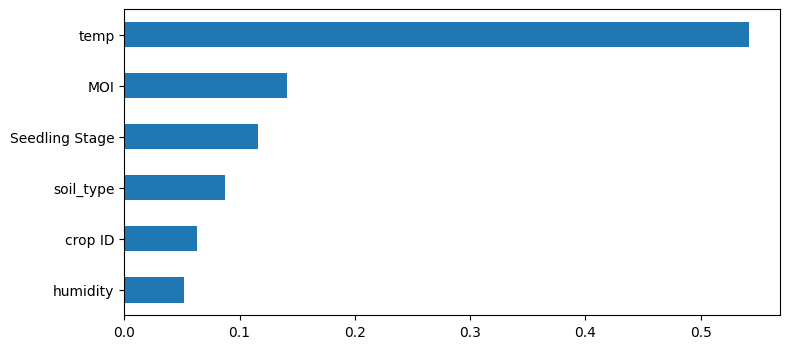

         variable  importance
0            temp    0.541737
1             MOI    0.140748
2  Seedling Stage    0.116030
3       soil_type    0.087145
4         crop ID    0.062686
5        humidity    0.051654


In [37]:
# Importancia POR VARIABLE (agregada)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

prep = best_pipe.named_steps["prep"]
est  = best_pipe.named_steps["model"]

fi = est.feature_importances_
feat_names = prep.get_feature_names_out()
assert len(fi) == len(feat_names)

enc = prep.named_transformers_["cat"]
sizes = [len(c) for c in enc.categories_]
idx = 0
groups = {}

for col, sz in zip(cat_cols, sizes):
    groups[col] = list(range(idx, idx + sz))
    idx += sz

for col in num_cols:
    groups[col] = [idx]
    idx += 1

assert idx == len(fi), "Descadre en el conteo de columnas transformadas."

var_importance = {col: float(np.sum(fi[inds])) for col, inds in groups.items()}

imp_series = pd.Series(var_importance).sort_values(ascending=False)

plt.figure(figsize=(8, max(3.5, 0.6*len(imp_series))))
imp_series.iloc[::-1].plot.barh()
plt.tight_layout()
plt.show()

# Tabla ordenada
imp_df_vars = imp_series.reset_index()
imp_df_vars.columns = ["variable", "importance"]
print(imp_df_vars)


In [ ]:
#Definición de la red neuronal
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

scaler_nn = StandardScaler()
X_train_nn = scaler_nn.fit_transform(X_train)
X_valid_nn = scaler_nn.transform(X_valid)

nn = Sequential()
nn.add(Dense(64, activation='relu', input_shape=(X_train_nn.shape[1],)))
nn.add(Dropout(0.2))
nn.add(Dense(32, activation='relu'))
nn.add(Dropout(0.2))
nn.add(Dense(16, activation='relu'))
nn.add(Dropout(0.2))
nn.add(Dense(1, activation='sigmoid'))

nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True, verbose=0)
history = nn.fit(X_train_nn, y_train, epochs=30, batch_size=32, validation_data=(X_valid_nn, y_valid), callbacks=[earlyStopping], verbose=1)

# Evaluación NN
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
y_proba_nn = nn.predict(X_valid_nn).ravel()
y_pred_nn = (y_proba_nn >= 0.5).astype(int)

print("=== NN - Classification Report (VALID) ===")
print(classification_report(y_valid, y_pred_nn, digits=4))
print("ROC-AUC (VALID):", roc_auc_score(y_valid, y_proba_nn))

cm_nn = confusion_matrix(y_valid, y_pred_nn, labels=[0,1])
cm_nn


Epoch 1/30
379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7614 - loss: 0.4637 - val_accuracy: 0.9463 - val_loss: 0.1386
Epoch 2/30
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9234 - loss: 0.1834 - val_accuracy: 0.9410 - val_loss: 0.1258
Epoch 3/30
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9421 - loss: 0.1433 - val_accuracy: 0.9459 - val_loss: 0.1131
Epoch 4/30
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9466 - loss: 0.1234 - val_accuracy: 0.9571 - val_loss: 0.0945
Epoch 5/30
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9538 - loss: 0.1104 - val_accuracy: 0.9624 - val_loss: 0.0852
Epoch 6/30
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9584 - loss: 0.1081 - val_accuracy: 0.9687 - val_loss: 0.0799
Epoch 7/30
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9624 - loss: 0.0966 - val_accuracy: 0.9680 - val_loss: 0.0766
Epoch 8/30
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9612 - loss: 0.0905 - val_accuracy: 0.

array([[1776,   11],
       [  15, 1231]])

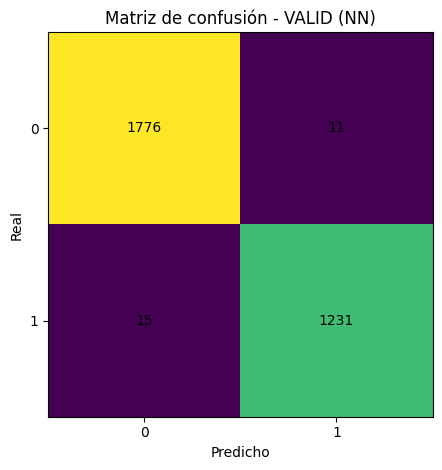

In [ ]:
#Matriz de confusión de la red neuronal
import matplotlib.pyplot as plt
import numpy as np

labels = ['0','1']
fig, ax = plt.subplots()
im = ax.imshow(cm_nn, interpolation='nearest')
ax.set_title("Matriz de confusión - VALID (NN)")
ax.set_xlabel("Predicho")
ax.set_ylabel("Real")
ax.set_xticks(np.arange(len(labels))); ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels); ax.set_yticklabels(labels)
for i in range(cm_nn.shape[0]):
    for j in range(cm_nn.shape[1]):
        ax.text(j, i, cm_nn[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()


In [ ]:
#Exportación del modelo
import joblib, pathlib
models_dir = pathlib.Path("models"); models_dir.mkdir(exist_ok=True)
joblib.dump(best_pipe, models_dir / "pipeline.joblib")


In [ ]:
#Exportación de encoders
from sklearn.preprocessing import LabelEncoder
import joblib, pathlib

encoders = {}
for col in ["crop ID", "soil_type", "Seedling Stage"]:
    le = LabelEncoder()
    le.fit(df[col].astype(str).str.strip())
    encoders[col] = le

pathlib.Path("models").mkdir(exist_ok=True)
joblib.dump(encoders, "models/label_encoders.pkl")
print("Encoders guardados en models/label_encoders.pkl")


Encoders guardados en models/label_encoders.pkl
